### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
np.random.seed(5)
import time
import sys
import warnings
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params, keep_prob, lamda):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    a1_c = tf.nn.dropout(a1_c, keep_prob, seed=2)
    
    #print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    #print(a1_p)
    a1_p = tf.nn.dropout(a1_p, keep_prob, seed=2)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    #print(a2_c)
    a2_c = tf.nn.dropout(a2_c, keep_prob, seed=2)
    
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    a2_p = tf.nn.dropout(a2_p, keep_prob, seed=2)
    
    #print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    #print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    a4 = tf.nn.dropout(a4, keep_prob, seed=2)
    #print(a4)
    
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    #print(a5)
    return a5

### 2. Load data

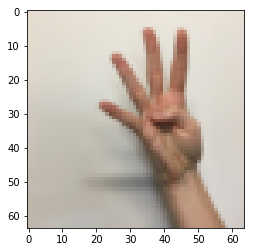

Digit in the image is 4
(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
indx = 2
plt.imshow(X_train[indx])
plt.show()
print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)



### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 4
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 4
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

### 4. (40pts) Build Convolution Neural Network model

In [5]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob, lamda):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params, keep_prob, lamda)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            old_cost = new_cost
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            new_cost = epoch_cost
            cost_history.append(epoch_cost)
            if(abs(old_cost - new_cost) < 0.00000000001):
                print("breaking" + str(old_cost) + str(new_cost))
                break;
            train_acc = accuracy.eval({x:X_train, y:y_train}) * 100
            test_acc = accuracy.eval({x:X_test, y:y_test}) * 100
            if(epoch % 20 == 0):
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Learning rate: ' , learning_rate)
        print('Keep probability: ' , keep_prob)
        print('L2 Regularizer lambda: ', lamda)
        elapsed_time = time.time() - start_time
        print("\nTime elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

Cost is 1.7920785 for iteration: 0
Cost is 1.3778673 for iteration: 20
Cost is 1.2812387 for iteration: 40
Cost is 1.2120475 for iteration: 60
Cost is 1.1689222 for iteration: 80
Cost is 1.1456516 for iteration: 100
Cost is 1.1214306 for iteration: 120
Cost is 1.1066836 for iteration: 140
Cost is 1.0972525 for iteration: 160
Cost is 1.0876019 for iteration: 180
Cost is 1.0712985 for iteration: 200
Cost is 1.0752808 for iteration: 220
Cost is 1.0651174 for iteration: 240
Cost is 1.0662962 for iteration: 260
Cost is 1.0666366 for iteration: 280
Cost is 1.0664647 for iteration: 300
Cost is 1.0675997 for iteration: 320
Cost is 1.060471 for iteration: 340
Cost is 1.0625565 for iteration: 360
Cost is 1.06039 for iteration: 380
Cost is 1.0560253 for iteration: 400
Cost is 1.053233 for iteration: 420
Cost is 1.0584716 for iteration: 440
Cost is 1.0561886 for iteration: 460


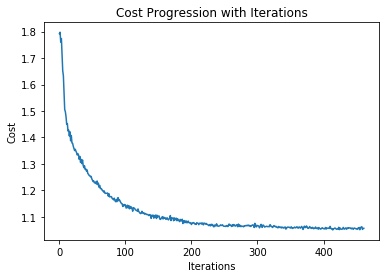

Train Accuracy:  99.21568632125854
Test Accuracy:  97.77777791023254
Learning rate:  0.012
Keep probability:  0.75
L2 Regularizer lambda:  10.0

Time elapsed :  10.801599570115407


In [6]:
for learning_rate in [0.012]:
    for keep_prob in [0.75]:
        for lam in [10.0]:
            #print("**********Learning rate******{}********Keep prob***********{}****lamda {}".format(learning_rate, keep_prob, lam))
            train_cnn_lenet5(461, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, learning_rate, keep_prob, lam)

### Architecture that acheived best accuracy

| Layer Number |	Layer Type |	Layer Size | Channels | Kernel Size	| Stride |	Padding	| Function | Regularization| Lambda | Keep prob| Kernel Initializer
|-------|--------------------|-----|---|-------|---|---|---|---|---|---|
|0 | Input | 64 X 64 | 3 | 
|1 | Convolution  | 32 X 32 | 8 | 4 X 4 | 2 | 1 | Relu | L2 | 10 | | Xavier
|1 | Pooling (P1)| 28 X 28 | 8 | 5 X 5 | 1 | 0 | Max | Dropout |  | 0.75
|2 | Convolution (C2) | 13 X 13 | 16 | 4 X 4 | 2 | 0 | Relu | L2 | 10 |  | Xavier
|2 | Pooling (P2)| 9 X 9 | 16 | 5 X 5 | 1 | 0 | Average | Dropout |  | 0.75
|3 | Flatten (F3)| 1296 | 
|4 | Fully connected Layer 4 (F4)| 108 | |  |  |  | Relu | Dropout |  | 0.75 | Xavier
|5 | Fully connected Layer 5 (F5)| 6 | |  |  |  | Sigmoid | Dropout |  | 0.75 | Xavier

### Major Observations 
1. Accuracy reduced as kernel size was reduced
2. Accuracy improved significantly after adding dropout for each layer except output layer



|Architecture|	Conv 1 Regularizer|	Conv/Pooling Kernel size| Pooling 1 Regularizer| Conv 2 Regularizer	|Pooling 2 Regularizer|	FC1 Initializer	|FC2 Initializer | Max Test Accuracy
|---|--------|---|---|---|---|---|---|---|---|--|
|Lenet5|	None|	2 / 2|	None|	None|	None|	None|	None|	88%|
|Lenet5| 	None|	2 / 2|	None|	None|	None|	Xavier|	Xavier|	93.86 %|
|Lenet5|	None|	4 / 5|	Dropout|	None|	Droput|	Xavier|	Xavier|	96.11 %
|Lenet5|	L2	|   4 / 5|	None|	L2	|   None	|Xavier	|Xavier	|92 %
|Lenet5|	L2	|   4 / 5|	Dropout|L2|	Dropout	|Xavier	|Xavier	|97.77 %
